In [2]:
import numpy as np
import json
import matplotlib.pyplot as plt
import pylab

from microfaune import audio, plot

# Labeling with Audacity

In [3]:
def convert_label_audacity_csv(file_path):

    file = open(file_path, 'r')
    lines_list = file.read()
    lines_list = lines_list.split('\n')
    lines_list = lines_list[::2]
    lines_list = lines_list[:-1]
    
    start_points = [round(float(line.split('\t')[0]), 2) for line in lines_list]
    end_points = [round(float(line.split('\t')[1]), 2) for line in lines_list]
    
    tab = np.array((start_points, end_points)).transpose()
    np.savetxt(file_path[:-4]+'.csv', tab, delimiter=";")
    
    return None


def convert_label_audacity_json(csv_file):
    
    data = np.genfromtxt(csv_file, delimiter=";")
    shape_data = np.shape(data)
    start_time = data[:,0]
    end_time = data[:,1]
    
    data_dict = []
    
    for i in range(shape_data[0]):
        data_dict.append({
            'id': 'wavesurfer_' + str(i), 
            'start': start_time[i], 
            'end': end_time[i],
            'annotation': 'bird'
        })
    
    with open(csv_file[:-4]+'.json', 'w') as outfile:
        json.dump(data_dict, outfile)
    
    return None

In [ ]:
txt_file = "C:/Users/Camille/Documents/MicroFaune/Git/labeling/test_audacity/test_labeling.txt"
convert_label_audacity_csv(txt_file)

csv_file = txt_file[:-4]+'.csv'
convert_label_audacity_json(csv_file)

# Labeling with Louis audio annotator

In [4]:
def number_bird_song(json_file_path):
    
    with open(json_file_path) as json_data:
        data_dict = json.load(json_data)
    
    return len(data_dict)


def prop_bird_song(json_file_path, wav_file_path):
    
    fs, data = audio.load_wav(wav_file_path)
    total_duration = len(data)/fs
    
    with open(json_file_path) as json_data:
        data_dict = json.load(json_data)
        
    bird_song_duration = 0
    
    for label in data_dict:
        bird_song_duration += label['end'] - label['start']
    
    return round(bird_song_duration/total_duration, 4)


def audio_charac_function_audio(json_file_path, wav_file_path):
    
    fs, data = audio.load_wav(wav_file_path)
    charac_func = np.zeros((len(data),1))
    
    with open(json_file_path) as json_data:
        data_dict = json.load(json_data)
        
    for label in data_dict:
        indx_start = int(label['start']*fs)
        indx_end = int(label['end']*fs)
        charac_func[indx_start:indx_end+1,0] = 1
    
    return charac_func

def plot_charac(json_file_path, wav_file_path):

    charac_func = audio_charac_function_audio(json_file_path, wav_file_path)
    fs, data = audio.load_wav(wav_file_path)
    
    t_plot = np.array(range(len(data)))
    t_plot = t_plot/fs
    
    plt.plot(t_plot,charac_func)
    plt.show()
    
    return None


def audio_charac_function_spec(window_length, overlap, charac_func_audio):
    
    size_spec = 2+int(duration/(window_length*(1-overlap)))
    size_audio = len(charac_func_audio)
    regroup_factor = int(size_audio / size_spec)
    
    charac_func_spec = np.zeros((size_spec,1))
    
    for i in range(size_spec):
        label_local = np.mean(charac_func_audio[i*regroup_factor : (i+1)*regroup_factor])
        if label_local>0.5:
            charac_func_spec[i] = 1
    
    return charac_func_spec


pylab.rcParams['figure.figsize'] = (20,2)

# Florent

Number of bird songs labelised: 11
Proportion of bird songs during extract: 80.51 %


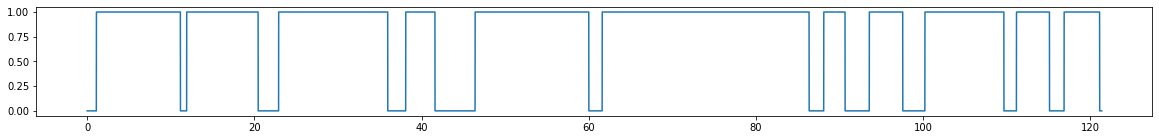

In [5]:
json_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-florent.json"
wav_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/static/wav/test_labeling.wav"

print("Number of bird songs labelised: " + str(number_bird_song(json_file_path)) )
print("Proportion of bird songs during extract: " + str(prop_bird_song(json_file_path, wav_file_path)*100) + " %" )
plot_charac(json_file_path, wav_file_path)

# Hadrien

Number of bird songs labelised: 21
Proportion of bird songs during extract: 64.2 %


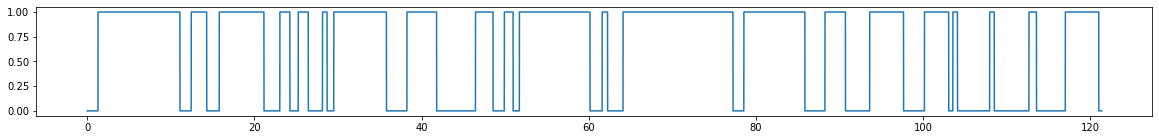

In [6]:
json_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-hadrien.json"
wav_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/static/wav/test_labeling.wav"

print("Number of bird songs labelised: " + str(number_bird_song(json_file_path)) )
print("Proportion of bird songs during extract: " + str(prop_bird_song(json_file_path, wav_file_path)*100) + " %" )

plot_charac(json_file_path, wav_file_path)

# Camille

Number of bird songs labelised: 26
Proportion of bird songs during extract: 56.74 %


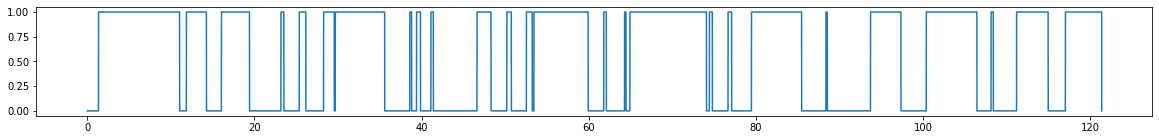

In [10]:
json_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-camille.json"
wav_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/static/wav/test_labeling.wav"

print("Number of bird songs labelised: " + str(number_bird_song(json_file_path)) )
print("Proportion of bird songs during extract: " + str(prop_bird_song(json_file_path, wav_file_path)*100) + " %" )
plot_charac(json_file_path, wav_file_path)

# Louis

Number of bird songs labelised: 18
Proportion of bird songs during extract: 75.22999999999999 %


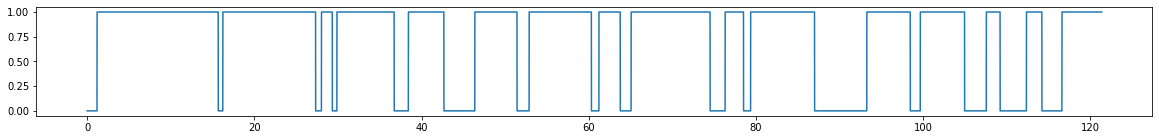

In [11]:
json_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-louis.json"
wav_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/static/wav/test_labeling.wav"

print("Number of bird songs labelised: " + str(number_bird_song(json_file_path)) )
print("Proportion of bird songs during extract: " + str(prop_bird_song(json_file_path, wav_file_path)*100) + " %" )
plot_charac(json_file_path, wav_file_path)

# Ysé

Number of bird songs labelised: 14
Proportion of bird songs during extract: 33.42 %


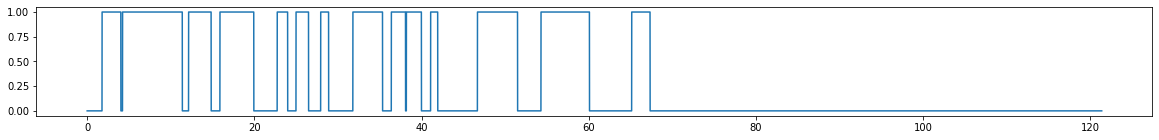

In [12]:
json_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-yse.json"
wav_file_path = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/static/wav/test_labeling.wav"

print("Number of bird songs labelised: " + str(number_bird_song(json_file_path)) )
print("Proportion of bird songs during extract: " + str(prop_bird_song(json_file_path, wav_file_path)*100) + " %" )
plot_charac(json_file_path, wav_file_path)

In [ ]:
%matplotlib notebook

In [ ]:
json_file_path1 = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-florent.json"
json_file_path2 = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-hadrien.json"
json_file_path3 = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-camille.json"
json_file_path4 = "C:/Users/Camille/Documents/MicroFaune/audio-annotator/compare_json_labels/test_labeling_labeled-louis.json"

plot_charac(json_file_path3, wav_file_path)

# Compute charac spec

In [ ]:
window_length = 0.020
overlap = 0.55

charac_func_audio = audio_charac_function_audio(json_file_path, wav_file_path)
charac_func_spec = audio_charac_function_spec(window_length, overlap, charac_func_audio)

#check length
[spec, t, f, x_fs] = audio.file2spec(wav_file_path, scale_spec="linear", window_length=window_length, overlap=overlap)
print(len(t))
print(len(charac_func_spec))

In [ ]:
#check proportion
yes_audio=np.where(charac_func_audio>0)
print(len(yes_audio[0])/len(charac_func_audio))
yes_spec=np.where(charac_func_spec>0)
print(len(yes_spec[0])/len(charac_func_spec))